<a href="https://colab.research.google.com/github/sugyan/stable-diffusion-morphing/blob/main/stable_diffusion_morphing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Diffusion morphing

Generate morphing animations from images generated by Stable Diffusion.

[Stable Diffusion](https://github.com/CompVis/stable-diffusion) by Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer and the [Stability.ai](https://stability.ai/) Team.

This notebook is hosted on [github.com/sugyan](https://github.com/sugyan/stable-diffusion-morphing)

## Setup


In [1]:
#@title NVIDIA GPU
!nvidia-smi

Thu Sep  8 01:45:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#@title Install `huggingface_hub`, enable custom widget manager
!pip install huggingface_hub

from google.colab import output
output.enable_custom_widget_manager()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 120 kB 7.7 MB/s 


In [3]:
#@title Authenticate huggingface token
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [8]:
#@title Download model file
!ls /root/.huggingface/token
!git config --global credential.helper store

%cd /content/
!git lfs install
!git clone https://huggingface.co/CompVis/stable-diffusion-v-1-4-original

/root/.huggingface/token
/content
Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'stable-diffusion-v-1-4-original'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 54 (delta 22), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (54/54), done.
tcmalloc: large alloc 1471086592 bytes == 0x56367535a000 @  0x7f5d9ffc02a4 0x563637f9511f 0x563637f7225b 0x563637f26f33 0x563637ecb22a 0x563637ecb6e6 0x563637ee8451 0x563637ee89e9 0x563637ee8f13 0x563637f8de12 0x563637e2f162 0x563637e15a65 0x563637e16725 0x563637e1572a 0x7f5d9f307c87 0x563637e1577a
tcmalloc: large alloc 2206621696 bytes == 0x5636cce4a000 @  0x7f5d9ffc02a4 0x563637f9511f 0x563637f7225b 0x563637f26f33 0x563637ecb22a 0x563637ecb6e6 0x563637ee8451 0x563637ee89e9 0x563637ee8f13 0x563637f8de12 0x563637e2f16

In [5]:
#@title Clone dependant projects, install them and set `sys.path`
%cd /content/
!git clone https://github.com/CompVis/taming-transformers.git
!git clone https://github.com/openai/CLIP.git
!pip install -e taming-transofmers
!pip install -e CLIP

import sys
sys.path.append("/content/taming-transformers")
sys.path.append("/content/CLIP")

/content
Cloning into 'taming-transformers'...
remote: Enumerating objects: 1335, done.
remote: Total 1335 (delta 0), reused 0 (delta 0), pack-reused 1335
Receiving objects: 100% (1335/1335), 409.77 MiB | 30.74 MiB/s, done.
Resolving deltas: 100% (277/277), done.
Cloning into 'CLIP'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 236 (delta 5), reused 8 (delta 4), pack-reused 221
Receiving objects: 100% (236/236), 8.93 MiB | 26.34 MiB/s, done.
Resolving deltas: 100% (116/116), done.
ERROR: taming-transofmers is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with bzr+http, bzr+https, bzr+ssh, bzr+sftp, bzr+ftp, bzr+lp, bzr+file, git+http, git+https, git+ssh, git+git, git+file, hg+file, hg+http, hg+https, hg+ssh, hg+static-http, svn+ssh, svn+http, svn+https, svn+svn, svn+file).
Looking in indexes: https://pypi.org/simple, https:/

In [6]:
#@title Clone stable-diffusion repository, install dependencies
%cd /content/
!git clone https://github.com/CompVis/stable-diffusion.git
!pip install \
    omegaconf \
    invisible-watermark \
    einops \
    pytorch-lightning \
    diffusers \
    transformers \
    kornia \
    -e stable-diffusion

/content
Cloning into 'stable-diffusion'...
remote: Enumerating objects: 313, done.
remote: Total 313 (delta 0), reused 0 (delta 0), pack-reused 313
Receiving objects: 100% (313/313), 42.62 MiB | 20.58 MiB/s, done.
Resolving deltas: 100% (114/114), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/stable-diffusion
     |████████████████████████████████| 79 kB 4.4 MB/s 
     |████████████████████████████████| 1.6 MB 16.2 MB/s 
     |████████████████████████████████| 706 kB 38.0 MB/s 
     |████████████████████████████████| 112 kB 60.7 MB/s 
     |████████████████████████████████| 4.7 MB 51.0 MB/s 
     |████████████████████████████████| 565 kB 11.6 MB/s 
     |████████████████████████████████| 117 kB 53.8 MB/s 
     |████████████████████████████████| 4.9 MB 36.7 MB/s 
     |████████████████████████████████| 13.1 MB 44.9 MB/s 
     |████████████████████████████████| 419 kB 55.6 MB/s 
     |██████████████████

In [9]:
#@title Load model
%cd /content/stable-diffusion/

from pathlib import Path

import torch
from omegaconf import OmegaConf

from ldm.models.diffusion.ddpm import LatentDiffusion
from ldm.util import instantiate_from_config


def load_model(ckpt: Path) -> LatentDiffusion:
    config = OmegaConf.load("configs/stable-diffusion/v1-inference.yaml")

    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    model.load_state_dict(sd, strict=False)
    model.to(device="cuda")
    model.eval()
    return model


model = load_model(Path("/content/stable-diffusion-v-1-4-original/sd-v1-4.ckpt"))

/content/stable-diffusion
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.23.self_attn.v_proj.bias', 'vision_model.embeddings.class_embedding', 'vision_model.encoder.layers.10.self_attn.v_proj.weight', 'vision_model.encoder.layers.13.mlp.fc2.bias', 'vision_model.encoder.layers.14.self_attn.out_proj.weight', 'vision_model.encoder.layers.18.self_attn.v_proj.weight', 'vision_model.encoder.layers.17.self_attn.out_proj.bias', 'vision_model.encoder.layers.19.layer_norm2.bias', 'vision_model.encoder.layers.23.self_attn.out_proj.weight', 'vision_model.encoder.layers.18.mlp.fc1.bias', 'vision_model.encoder.layers.18.layer_norm1.bias', 'vision_model.encoder.layers.8.self_attn.k_proj.weight', 'vision_model.encoder.layers.18.self_attn.out_proj.bias', 'vision_model.encoder.layers.8.self_attn.q_proj.weight', 'vision_model.encoder.layers.2.self_attn.out_proj.bias', 'vision_model.encoder.layers.8.layer_norm1.weight', 'vision_mode

## Prepare to generate images

In [10]:
#@title Define `generate` function
from contextlib import nullcontext
from typing import Any

import numpy as np
from PIL import Image

from ldm.models.diffusion.ddim import DDIMSampler


def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")


def generate(c: torch.Tensor, start_code: torch.Tensor, ddim_steps: int = 50) -> Image:
    assert c.shape[0] == 1 and start_code.shape[0] == 1
    batch_size = 1

    device = get_device()
    precision_scope = torch.autocast if device.type == "cuda" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                uc = model.get_learned_conditioning(batch_size * [""])
                shape = [4, 64, 64]
                samples_ddim, _ = DDIMSampler(model).sample(
                    S=ddim_steps,
                    conditioning=c,
                    batch_size=batch_size,
                    shape=shape,
                    verbose=False,
                    unconditional_guidance_scale=7.5,
                    unconditional_conditioning=uc,
                    eta=0.0,
                    x_T=start_code,
                )

                x_samples_ddim = model.decode_first_stage(samples_ddim)
                x_samples_ddim = torch.clamp(
                    (x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0
                )
                image = (
                    255.0 * x_samples_ddim.cpu().permute(0, 2, 3, 1).numpy()[0]
                ).astype(np.uint8)
                return Image.fromarray(image)

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:21<00:00,  2.31it/s]


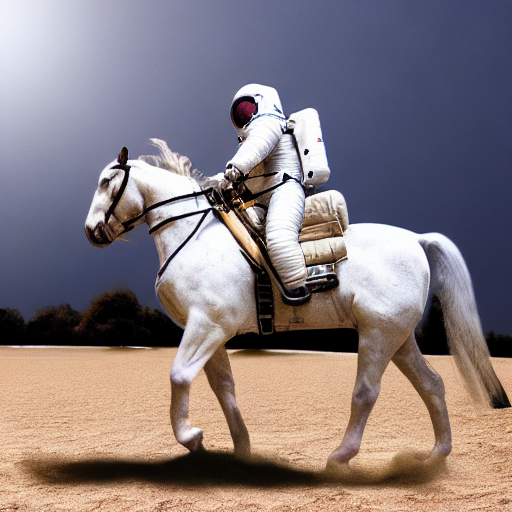

In [11]:
#@title Check if `generate` works
prompt = "a photograph of an astronaut riding a horse"
generate(
    model.get_learned_conditioning([prompt]), 
    torch.randn([1, 4, 64, 64], device=get_device())
)

## Generate frames

Define `inputs` for morphing (list of `seed` and `prompt`)

In [13]:
from dataclasses import dataclass
from typing import List


@dataclass
class Input:
    seed: int
    prompt: str


inputs: List[Input] = [
    Input(seed=42, prompt="photo of an apple"),
    Input(seed=42, prompt="photo of a pineapple"),
    Input(seed=420, prompt="photo of a pineapple"),
]

### Run

if `loop` is `True`, `interpolation_steps * len(inputs)` images will be generated.

In [19]:
import shutil
from math import sinh, sqrt
from pathlib import Path
from typing import List

import numpy as np
from pytorch_lightning import seed_everything


def morphing(inputs: List[Input], steps: int, ddim_steps, loop: bool) -> None:
    outdir = Path("/content/stable-diffusion/outputs/morphing")
    shutil.rmtree(outdir, ignore_errors=True)
    outdir.mkdir(parents=True)

    start_codes = []
    for input in inputs:
        seed_everything(input.seed)
        start_codes.append(torch.randn([1, 4, 64, 64], device="cpu").to(get_device()))

    a = np.arccosh(5.0)
    idx = 0
    for i in range(len(inputs)):
        i0, i1 = i, (i + 1) % len(inputs)
        n0 = start_codes[i0]
        n1 = start_codes[i1]
        c0 = model.get_learned_conditioning([inputs[i0].prompt])
        c1 = model.get_learned_conditioning([inputs[i1].prompt])
        for j in range(steps):
            print(f"genearate image {idx}: {i}/{len(inputs)}, {j}/{steps}")
            t = j / steps
            xc = sinh(a * (t * 2.0 - 1.0)) / sinh(a) / 2.0 + 0.5
            xn = 2.0 * t**2 if t < 0.5 else 1.0 - 2.0 * (1.0 - t) ** 2
            
            c = c0 * (1.0 - xc) + c1 * xc
            if inputs[i0].seed == inputs[i1].seed:
                start_code = n0
            else:
                start_code = n0 * sqrt(1.0 - xn) + n1 * sqrt(xn)
            img = generate(c, start_code, ddim_steps)
            img.save(outdir / f"{idx:04d}.png")
            idx += 1
            if not loop and i == len(inputs) - 1:
                break


interpolation_steps = 15 #@param {type:"integer"}
ddim_steps = 15 #@param {type:"integer"}
loop = True #@param {type:"boolean"}

morphing(inputs, interpolation_steps, ddim_steps, loop)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.seed:Global seed set to 420


genearate image 0: 0/3, 0/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]


genearate image 1: 0/3, 1/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


genearate image 2: 0/3, 2/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


genearate image 3: 0/3, 3/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


genearate image 4: 0/3, 4/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


genearate image 5: 0/3, 5/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


genearate image 6: 0/3, 6/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 7: 0/3, 7/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 8: 0/3, 8/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 9: 0/3, 9/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


genearate image 10: 0/3, 10/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 11: 0/3, 11/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 12: 0/3, 12/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 13: 0/3, 13/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 14: 0/3, 14/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 15: 1/3, 0/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


genearate image 16: 1/3, 1/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 17: 1/3, 2/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 18: 1/3, 3/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 19: 1/3, 4/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 20: 1/3, 5/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 21: 1/3, 6/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 22: 1/3, 7/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 23: 1/3, 8/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 24: 1/3, 9/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


genearate image 25: 1/3, 10/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


genearate image 26: 1/3, 11/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


genearate image 27: 1/3, 12/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


genearate image 28: 1/3, 13/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 29: 1/3, 14/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 30: 2/3, 0/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 31: 2/3, 1/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


genearate image 32: 2/3, 2/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 33: 2/3, 3/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


genearate image 34: 2/3, 4/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 35: 2/3, 5/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


genearate image 36: 2/3, 6/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]


genearate image 37: 2/3, 7/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 38: 2/3, 8/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 39: 2/3, 9/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 40: 2/3, 10/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 41: 2/3, 11/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 42: 2/3, 12/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


genearate image 43: 2/3, 13/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]


genearate image 44: 2/3, 14/15
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 16 timesteps


DDIM Sampler: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]


## Create video from frames 

In [20]:
#@title Create video by `ffmpeg` and display
import subprocess
from base64 import b64encode
from IPython import display

output_path = "/content/out.mp4" #@param {type:"string"}
fps = 12 #@param {type:"integer"}
cmd = [
    'ffmpeg',
    '-y',
    '-vcodec', 'png',
    '-r', str(fps),
    '-start_number', str(0),
    '-i', "/content/stable-diffusion/outputs/morphing/%04d.png",
    '-c:v', 'libx264',
    '-vf',
    f'fps={fps}',
    '-pix_fmt', 'yuv420p',
    '-crf', '17',
    '-preset', 'veryfast',
    output_path,
]
process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
stdout, stderr = process.communicate()
if process.returncode != 0:
    print(stderr)
    raise RuntimeError(stderr)

mp4 = open(output_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.display(display.HTML(f'<video controls loop><source src="{data_url}" type="video/mp4"></video>'))

In [21]:
#@title Download video
from google.colab import files
files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>